In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from skimage.metrics import structural_similarity as ssim
from skimage import io
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy as CC
from tensorflow.keras.preprocessing import image
import os

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

device_name = '/GPU:0'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=0.2)
# test_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_dir = 'Datasets/train'
# test_data_dir = '/content/drive/MyDrive/Datasets/dataset/test'

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='training',
    shuffle=True)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='validation')

Found 2198 images belonging to 5 classes.
Found 548 images belonging to 5 classes.


In [ ]:
# model = tf.keras.models.load_model('my_model.h5')

In [ ]:
base_model = ResNet50V2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

class_layers = base_model.output
class_layers = GlobalAveragePooling2D()(class_layers)
class_layers = Dense(64, activation='relu')(class_layers)
class_layers = Dropout(0.1)(class_layers)
class_layers = Dense(64, activation='relu')(class_layers)
class_layers = Dropout(0.1)(class_layers)
predictions = Dense(5, activation='softmax')(class_layers)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(optimizer=Adam(), loss=CC(from_logits=False), metrics=['accuracy'])

In [ ]:
with tf.device(device_name):

  history = model.fit(
      train_generator,
      batch_size = 64,
      epochs=15,
      validation_data=validation_generator,
      validation_batch_size = 64,
      verbose=1
  )

Epoch 1/15
18/18 [==============================] - 12s 308ms/step - loss: 1.0321 - accuracy: 0.6019 - val_loss: 0.6211 - val_accuracy: 0.7774
Epoch 2/15
18/18 [==============================] - 5s 256ms/step - loss: 0.5256 - accuracy: 0.8080 - val_loss: 0.4594 - val_accuracy: 0.8285
Epoch 3/15
18/18 [==============================] - 5s 251ms/step - loss: 0.3683 - accuracy: 0.8699 - val_loss: 0.3957 - val_accuracy: 0.8577
Epoch 4/15
18/18 [==============================] - 5s 263ms/step - loss: 0.2902 - accuracy: 0.8963 - val_loss: 0.3600 - val_accuracy: 0.8668
Epoch 5/15
18/18 [==============================] - 5s 272ms/step - loss: 0.2235 - accuracy: 0.9245 - val_loss: 0.3780 - val_accuracy: 0.8759
Epoch 6/15
18/18 [==============================] - 5s 263ms/step - loss: 0.1833 - accuracy: 0.9431 - val_loss: 0.3520 - val_accuracy: 0.8887
Epoch 7/15
18/18 [==============================] - 5s 267ms/step - loss: 0.1555 - accuracy: 0.9504 - val_loss: 0.3635 - val_accuracy: 0.8814
Epoch

In [ ]:
model.save('my_model.h5')

In [ ]:
images_by_label = {}

In [ ]:
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))  # Resize the image to match the input size of the model
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
    img_array = img_array / 255.0  # Normalize the pixel values (if necessary)
    return img_array

test_image_path = 'Datasets/train/daisy/10140303196_b88d3d6cec.jpg'

test_image = preprocess_image(test_image_path)
test_image.max(), test_image.min()

(1.0, 0.0)

In [ ]:
prediction = model.predict(test_image)
pred_label = prediction.argmax(axis=1)
pred_label[0]

1/1 [==============================] - 0s 14ms/step


0

In [ ]:
with tf.device(device_name):

  predicted_label = os.listdir('Datasets/train')[pred_label[0]]

  if predicted_label not in images_by_label:

    images_by_label[predicted_label] = []
    predicted_label_dir = os.listdir('Datasets/train/' + predicted_label)
    for image_path in predicted_label_dir:
      image_arr = preprocess_image('Datasets/train/' + predicted_label + '/' + image_path)
      images_by_label[predicted_label].append(image_arr)

len(images_by_label[predicted_label])

501

In [ ]:
ssim_score = np.array([])

with tf.device(device_name):
  for ssim_image in images_by_label[predicted_label]:
    ssim_score = np.append(ssim_score, (ssim(test_image[0], ssim_image[0], channel_axis=2, win_size=11, data_range=1)))

most_corresponding_image = ssim_score.argmax()

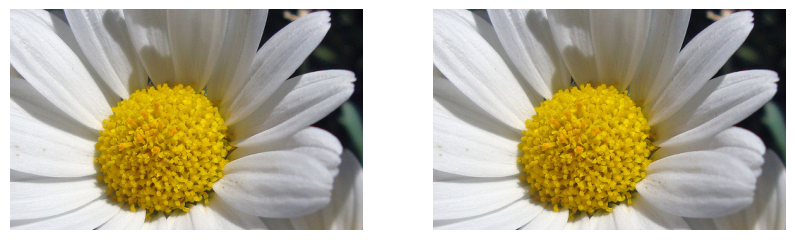

In [ ]:
img1 = io.imread(test_image_path)
img2 = io.imread('Datasets/train/' + predicted_label + '/' + predicted_label_dir[most_corresponding_image])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')

plt.show()